In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests

In [2]:
nyc_raw = requests.get('https://github.com/nychealth/coronavirus-data/blob/master/tests-by-zcta.csv').text
nyc_soup = BeautifulSoup(nyc_raw, 'lxml')

In [3]:
soup_content = nyc_soup.find('div', class_='application-main')
nyc_table = soup_content.find('table', class_='js-csv-data csv-data js-file-line-container')
table = nyc_table.find_all('tbody')
rows = table[0].find_all('tr')

In [4]:
zipcodes = []
positive_tests = []
total_tests = []
percentage_total = []

for row in rows:    
    columns = row.find_all('td')
    
    zipcode = columns[1].text
    positive_test = columns[2].text
    total_test = columns[3].text
    percentage = columns[4].text
    
    zipcodes.append(zipcode)
    positive_tests.append(positive_test)
    total_tests.append(total_test)
    percentage_total.append(percentage)

In [5]:
df_covid19 = pd.DataFrame(list(zip(zipcodes, positive_tests, total_tests, percentage_total)), \
                  columns =['Zip Code', 'Positive Tests','Total Tests', 'Percentage of Total']) 
df_covid19.drop([0], axis = 0, inplace = True)
df_covid19.reset_index(drop=True).head(10)

,Zip Code,Positive Tests,Total Tests,Percentage of Total
0,10001,288,685,42.04
1,10002,780,1603,48.66
2,10003,368,977,37.67
3,10004,26,75,34.67
4,10005,48,156,30.77
5,10006,16,68,23.53
6,10007,46,167,27.54
7,10009,561,1377,40.74
8,10010,216,695,31.08
9,10011,427,1025,41.66


In [6]:
nyc_stat_raw = requests.get('http://www.city-data.com/zipmaps/New-York-New-York.html').text
stat_soup = BeautifulSoup(nyc_stat_raw, 'lxml') 

In [7]:
stat_soup_content = stat_soup.find('div',{"id": "body"}, class_='container-fluid')
table_data = stat_soup_content.find_all('div', class_='zip data-block')

In [8]:
def clean_pop(element):
    element = str(element)
    element = element.replace(' ','') # removes empty space 
    element = element.replace(',','') # removes comma 
    element = float(element)          # changes data type to float 
    return element


def clean_money(element):
    element = str(element)
    element = element.replace('$','') # removes $ sign
    element = element.replace(' ','') # removes empty space
    element = element.replace(',','') # removes comma 
    element = float(element)          # changes data type to float 
    return element

def clean_unemploy(element):
    element = str(element)
    element = element.replace(':', '')
    element = element.replace(' ', '')
    element = element.replace('%', '')
    element = float(element)
    return element

In [9]:
zipcodes = []
populations = []
incomes = []
houses = []
unemploys = []

for data in table_data:
    try:
        zipcode = data.find_all('strong')[0].text[9:14]
        
        population = data.find_all('b')[9].next_sibling
        population = clean_pop(population)
        
    
        income = data.find('b', text = 'Estimated median household income in 2016:').next_sibling
        income = clean_money(income)
        
        house = data.find('b', text = 'Estimated median house/condo value in 2016:').next_sibling
        house = clean_money(house)
        
        unemploy = data.find('b', text = 'Unemployment').next_sibling
        unemploy = clean_unemploy(unemploy)
        
        zipcodes.append(zipcode)
        populations.append(population)
        incomes.append(income)
        houses.append(house)
        unemploys.append(unemploy)
        
    except Exception as e:
        pass

In [10]:
df_stats = pd.DataFrame(list(zip(zipcodes,populations,incomes, houses, unemploys)), \
                  columns =['Zip Code', 'Population Density', 'Median Income', 'Median House/Condo Value', 'Unemployment Rate'])

df_stats.tail(10)

,Zip Code,Population Density,Median Income,Median House/Condo Value,Unemployment Rate
168,11432,30530.0,54446.0,600682.0,7.9
169,11433,22681.0,47721.0,417214.0,13.3
170,11434,20760.0,59837.0,422320.0,7.5
171,11435,38593.0,57561.0,377924.0,9.8
172,11436,25889.0,69610.0,410333.0,8.8
173,11691,23247.0,42899.0,482588.0,7.7
174,11692,19708.0,44089.0,395793.0,9.5
175,11693,12228.0,56062.0,323538.0,6.5
176,11694,15760.0,82428.0,678487.0,5.2
177,11697,1795.0,105095.0,608341.0,3.1


In [11]:
df_merged = pd.merge(left=df_covid19, right=df_stats, left_on='Zip Code', right_on='Zip Code')
df_merged.tail()

,Zip Code,Positive Tests,Total Tests,Percentage of Total,Population Density,Median Income,Median House/Condo Value,Unemployment Rate
169,11691,1738,2914,59.64,23247.0,42899.0,482588.0,7.7
170,11692,457,815,56.07,19708.0,44089.0,395793.0,9.5
171,11693,275,535,51.4,12228.0,56062.0,323538.0,6.5
172,11694,551,1094,50.37,15760.0,82428.0,678487.0,5.2
173,11697,79,177,44.63,1795.0,105095.0,608341.0,3.1


In [12]:
API_KEY = '5e232949c48244eb888c484b236c9534'

In [13]:
import json 

#creates list of zipcodes from df_merged 
df_zips = df_merged['Zip Code'].values

latitudes = [] #initializes empty list to append latitude data
longitudes = [] #initializes empty list to append longitude data

for zipcode in df_zips:
    location_input = str(zipcode) + " New York City, NY" # correct location input format 
    url = 'https://api.opencagedata.com/geocode/v1/json?q={}&key={}'.format(location_input, API_KEY) # correct url format
    obj = json.loads(requests.get(url).text)  # Gets the json file, stores in a dictionary
    
    results = obj['results'] # gets the 'results' key
    latitude = results[0]['geometry']['lat'] # gets the 'latitude' data 
    longitude = results[0]['geometry']['lng'] #gets the 'longitude' data
    
    latitudes.append(latitude) # Appends data to the list of latitudes
    longitudes.append(longitude) # Appends data to the list of longitudes

In [27]:
df_merged['Latitude'] = latitudes
df_merged['Longitude'] = longitudes
df_merged.drop(['Total Tests'], axis = 1, inplace = True)
df_merged.head()

,Zip Code,Latitude,Longitude,Population Density,Median Income,Median House/Condo Value,Unemployment Rate,Positive Tests,Percentage of Total
0,10001,40.729825,-73.960752,38085.0,88701.0,511113.0,5.3,288,42.04
1,10002,40.710636,-73.982200,90078.0,37071.0,675823.0,6.8,780,48.66
2,10003,40.731607,-73.988484,99889.0,104972.0,1068952.0,4.3,368,37.67
3,10004,40.700732,-74.013475,5515.0,128161.0,1387385.0,4.2,26,34.67
4,10005,40.705636,-74.008900,120158.0,135514.0,1581508.0,2.6,48,30.77


In [28]:
df_merged = df_merged[['Zip Code','Latitude','Longitude','Population Density','Median Income','Median House/Condo Value',  
                       'Unemployment Rate', 'Positive Tests', 'Percentage of Total']]
df_merged.head()

,Zip Code,Latitude,Longitude,Population Density,Median Income,Median House/Condo Value,Unemployment Rate,Positive Tests,Percentage of Total
0,10001,40.729825,-73.960752,38085.0,88701.0,511113.0,5.3,288,42.04
1,10002,40.710636,-73.982200,90078.0,37071.0,675823.0,6.8,780,48.66
2,10003,40.731607,-73.988484,99889.0,104972.0,1068952.0,4.3,368,37.67
3,10004,40.700732,-74.013475,5515.0,128161.0,1387385.0,4.2,26,34.67
4,10005,40.705636,-74.008900,120158.0,135514.0,1581508.0,2.6,48,30.77


In [41]:
#df_geolocation = df_merged[['Zip Code', 'Latitude','Longitude']]
#df_geolocation.to_csv('NYC_zipcodes_coordinates.csv', index=False)

In [44]:
# Only execute when updating Covid19 data without needing to use the OpenCage API 


#df_geolocation = pd.read_csv('NYC_zipcodes_coordinates.csv')
#df_merged['Latitude'] = df_geolocation['Latitude']
#df_merged['Longitude'] = df_geolocation['Longitude']
#df_merged.head()

In [40]:
df_merged.to_csv('NYC_compiled_data.csv', index=False)

In [32]:
df_fin = pd.read_csv('NYC_compiled_data.csv')
df_fin.head()

,Zip Code,Latitude,Longitude,Population Density,Median Income,Median House/Condo Value,Unemployment Rate,Positive Tests,Percentage of Total
0,10001,40.729825,-73.960752,38085.0,88701.0,511113.0,5.3,288,42.04
1,10002,40.710636,-73.982200,90078.0,37071.0,675823.0,6.8,780,48.66
2,10003,40.731607,-73.988484,99889.0,104972.0,1068952.0,4.3,368,37.67
3,10004,40.700732,-74.013475,5515.0,128161.0,1387385.0,4.2,26,34.67
4,10005,40.705636,-74.008900,120158.0,135514.0,1581508.0,2.6,48,30.77


In [72]:
from geopy.geocoders import Nominatim

from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

#!pip install folium
import folium

In [30]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="nyc_explorer")
location = geolocator.geocode(address)
nyc_latitude = location.latitude
nyc_longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(nyc_latitude, nyc_longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [33]:
map_nyc = folium.Map(location=[nyc_latitude, nyc_longitude], tiles="OpenStreetMap", zoom_start=10)

# add markers to map
for lat, lng, zipcode in zip(df_fin['Latitude'], df_fin['Longitude'], df_fin['Zip Code']):
    label = '{}' .format(zipcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_nyc)  
    
map_nyc

In [22]:
with open('nyc_zip_code.geojson', 'r') as jsonFile:
    geodata = json.load(jsonFile)
tmp = geodata
zips = df_fin['Zip Code'].tolist()

geozips = []
for i in range(len(tmp['features'])):
    if int(tmp['features'][i]['properties']['postalcode']) in zips:
        geozips.append(tmp['features'][i])
        
new_json = dict.fromkeys(['type','features'])
new_json['type'] = 'FeatureCollection'
new_json['features'] = geozips

open('updated-file.json', 'w').write(
    json.dumps(new_json, sort_keys = True, indent = 4, separators = (',', ': '))
)

1669359

In [81]:
def create_map(table, zipcodes, mapped_feature, add_text = ''):
    table['Zip Code'] = table['Zip Code'].astype('int').astype('str')
    nyc_geo = r'updated-file.json'
    m = folium.Map(location=[nyc_latitude, nyc_longitude], tiles="OpenStreetMap", zoom_start=10)
    m.choropleth(
        geo_data = nyc_geo,
        fill_opacity = 0.8,
        line_opacity = 0.2,
        data = table,
        key_on = 'feature.properties.postalcode',
        columns = [zipcodes, mapped_feature],
        fill_color = 'RdYlGn',
        legend_name = (' ').join(mapped_feature.split('_')).title() + ' ' + add_text + ' Across NYC'
    )
    folium.LayerControl().add_to(m)
    
    m.save(outfile = mapped_feature + '_map.html')
    

In [82]:
create_map(df_fin, zipcodes = 'Zip Code', mapped_feature = 'Population Density', add_text= 'Distribution')

create_map(df_fin, zipcodes = 'Zip Code', mapped_feature = 'Median Income', add_text= 'Distribution')

create_map(df_fin, zipcodes = 'Zip Code', mapped_feature = 'Positive Tests', add_text= 'for Covid19 Distribution')

create_map(df_fin, zipcodes = 'Zip Code', mapped_feature = 'Percentage of Total', add_text = 'Number of Tests Distribution')

In [89]:
from sklearn.linear_model import LinearRegression
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
df_fin.describe()

,Zip Code,Latitude,Longitude,Population Density,Median Income,Median House/Condo Value,Unemployment Rate,Positive Tests,Percentage of Total
count,174.000000,174.000000,174.000000,174.000000,174.000000,1.740000e+02,174.000000,174.000000,174.000000
mean,10817.172414,40.724501,-73.918518,44545.942529,68950.448276,6.532363e+05,6.451149,858.218391,48.532414
std,577.219140,0.084185,0.099282,31226.516791,34363.825219,3.283589e+05,2.673500,590.683447,7.923491
min,10001.000000,40.502362,-74.251220,1245.000000,22447.000000,3.152100e+04,0.400000,16.000000,23.530000
25%,10302.250000,40.674593,-73.977803,19971.000000,47485.750000,4.577815e+05,4.600000,415.750000,43.640000
50%,11202.000000,40.725026,-73.921721,37988.000000,61817.000000,5.601150e+05,6.050000,715.500000,49.755000
75%,11361.750000,40.778962,-73.849155,60757.250000,83917.250000,7.617572e+05,7.900000,1240.750000,54.310000
max,11697.000000,40.898574,-73.712255,155635.000000,260372.000000,2.219817e+06,16.000000,3211.000000,68.040000


In [59]:
df_fin.corr()

,Latitude,Longitude,Population Density,Median Income,Median House/Condo Value,Unemployment Rate,Positive Tests,Percentage of Total
Latitude,1.000000,0.360609,0.366628,-0.129977,-0.089168,0.251879,0.031631,0.005763
Longitude,0.360609,1.000000,-0.199729,-0.216587,-0.332702,0.269090,0.093606,0.470602
Population Density,0.366628,-0.199729,1.000000,0.033837,0.288336,0.020715,0.029380,-0.143439
Median Income,-0.129977,-0.216587,0.033837,1.000000,0.731534,-0.699027,-0.520116,-0.689346
Median House/Condo Value,-0.089168,-0.332702,0.288336,0.731534,1.000000,-0.554730,-0.430432,-0.589718
Unemployment Rate,0.251879,0.269090,0.020715,-0.699027,-0.554730,1.000000,0.380613,0.554842
Positive Tests,0.031631,0.093606,0.029380,-0.520116,-0.430432,0.380613,1.000000,0.569508
Percentage of Total,0.005763,0.470602,-0.143439,-0.689346,-0.589718,0.554842,0.569508,1.000000


In [51]:
def histogram_maker(dataframe, feature_name):
    count, bin_edges = np.histogram(dataframe[feature_name])
    
    dataframe[feature_name].plot(kind='hist', figsize=(8,5), xticks = bin_edges)
    
    plt.title('Histogram of ' + (' ').join(feature_name.split('_')).title() + ' in NYC')
    plt.xlabel((' ').join(feature_name.split('_')).title())
    plt.ylabel('Frequency')
    
    plt.show()

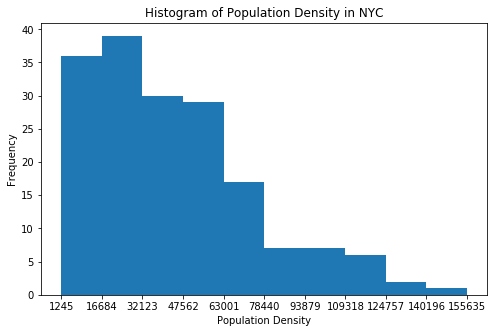

In [52]:
histogram_maker(df_fin, 'Population Density')

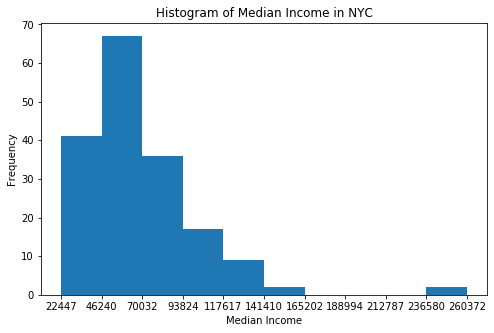

In [53]:
histogram_maker(df_fin, 'Median Income')

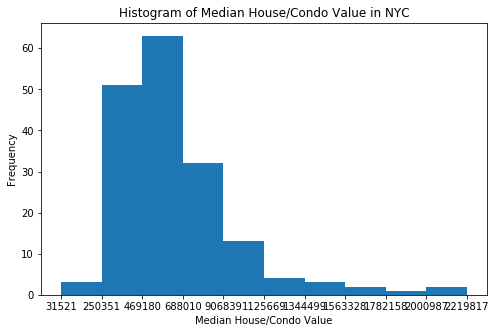

In [54]:
histogram_maker(df_fin, 'Median House/Condo Value')

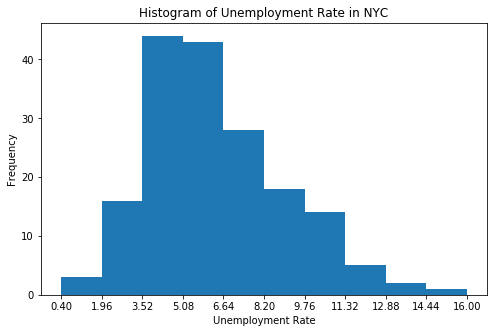

In [56]:
histogram_maker(df_fin, 'Unemployment Rate')

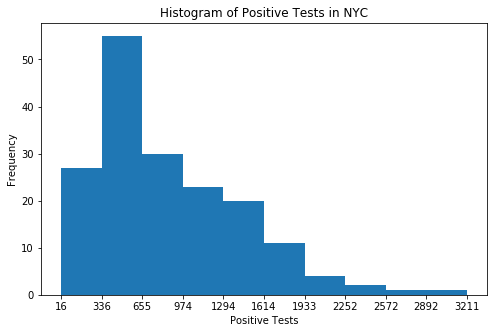

In [57]:
histogram_maker(df_fin, 'Positive Tests')

In [83]:
def basic_analysis(table, x, xlabel):
    coef, p_value = pearsonr(table[x].values, df_fin['Positive Tests'].values.flatten())
    print('Correlation coefficient: {} and p_value: {}' .format(coef,p_value))

# regression plot 
    ax = sns.regplot(x=x, y="Positive Tests", data=df_fin)
    ax.set(xlabel=xlabel, ylabel='Number of Positive Tests')

Correlation coefficient: -0.52011570764286 and p_value: 1.9058449389951736e-13


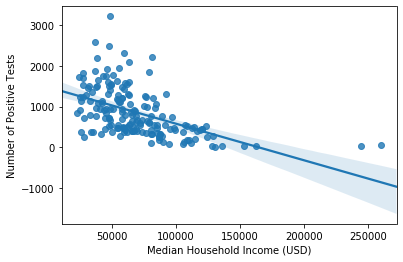

In [84]:
basic_analysis(df_fin, 'Median Income', 'Median Household Income (USD)')

Correlation coefficient: 0.02938043469297371 and p_value: 0.7003528118194067


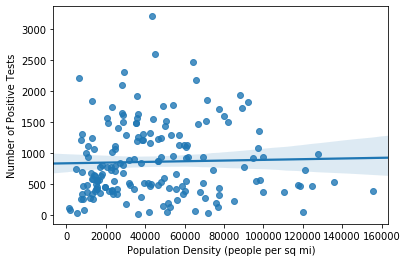

In [85]:
basic_analysis(df_fin, 'Population Density', 'Population Density (people per sq mi)')

Correlation coefficient: -0.43043179425873007 and p_value: 3.064685847546657e-09


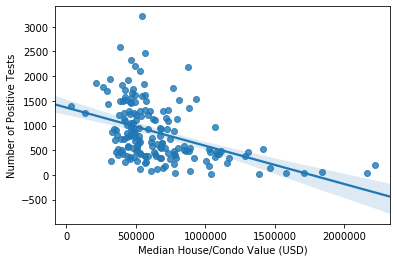

In [86]:
basic_analysis(df_fin, 'Median House/Condo Value', 'Median House/Condo Value (USD)')

Correlation coefficient: 0.3806130264890971 and p_value: 2.2096450736346468e-07


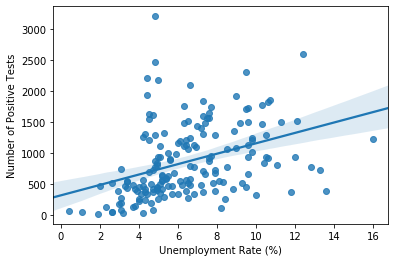

In [87]:
basic_analysis(df_fin, 'Unemployment Rate', 'Unemployment Rate (%)')

In [90]:
X = df_fin[['Median Income','Median House/Condo Value','Unemployment Rate']]
Y = df_fin[['Positive Tests']]